In [60]:
import matplotlib.pylab as plt
import seaborn as sns

import numpy as np
import pandas as pd 

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, f1_score ,confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn import set_config

In [61]:
%matplotlib inline
set_config(display="diagram")

#### Estamos utilizando um dataset para discriminação de vozes masculinas e femininas. https://www.kaggle.com/datasets/primaryobjects/voicegender

# Importando dataset

In [62]:
df = pd .read_csv('../input/voice.csv')

#### É importante conhecer o formato dos dados que estamos lidando. Possuímos um dataset com 3168 amostras e 21 features para a classificação

In [63]:
Nsamples, Nfeatures = df.shape
print(f'Nsamples:{Nsamples}\nNfeatures: {Nfeatures}')

Nsamples:3168
Nfeatures: 21


In [64]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


## Enconding dos Labels

#### As classes estão definidas como 'male' e 'female', entretando para o treinamento precisamos necessitamos que esse valores sejam variáveis inteiras discretas. Para isso estruturamos um enconding das classes onde a classa 'male' se torna 0 e a classe 'female' 1

In [65]:
print(df.label.value_counts())
dict = {'male':0,'female':1}
df.label.replace(dict,inplace = True)
df.head()

male      1584
female    1584
Name: label, dtype: int64


,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,0
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,0
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,0
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,0
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,0


#### Como o número de amostras entre as classes são iguais não será utilizar técnicas de balanceamento das classes como SMOTE ou Bootstrapping na validação.

## Correlação de Features 

<AxesSubplot:>

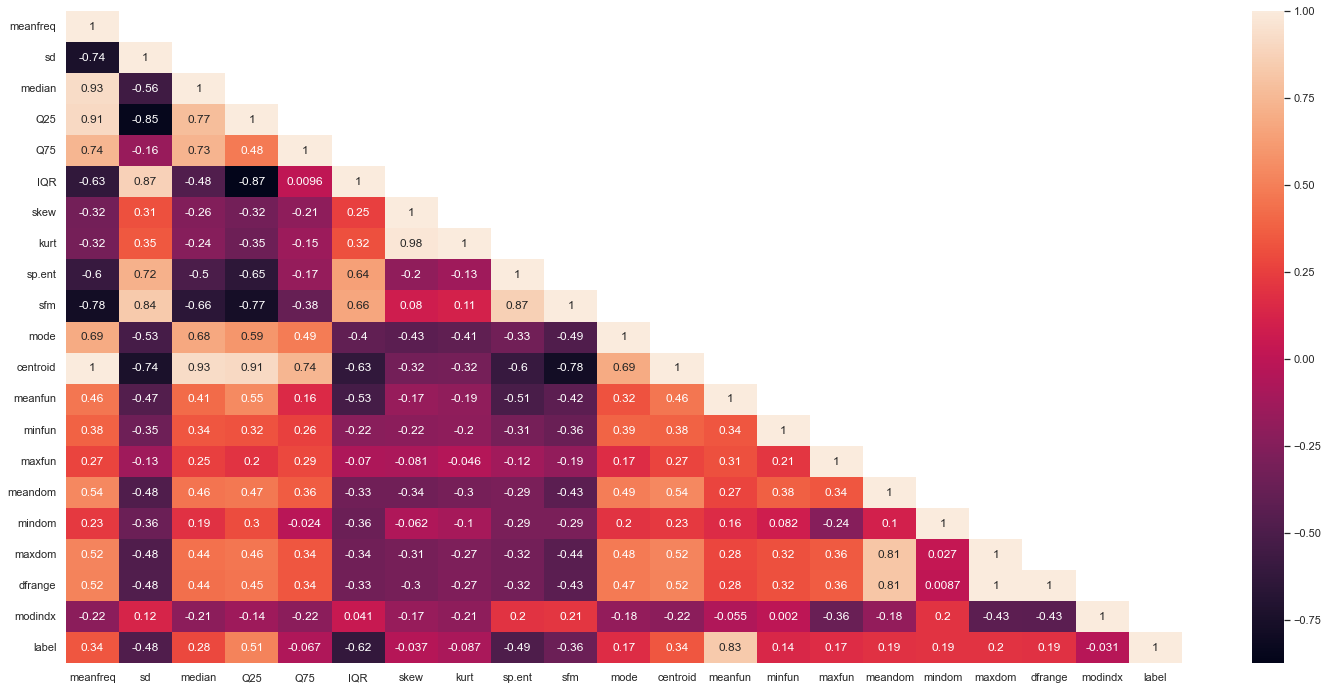

In [66]:
sns.set(style='whitegrid',color_codes=True)
cor_mat= df.corr(method='pearson')
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False ## triangular inferior
fig=plt.gcf()
fig.set_size_inches(25,12)
sns.heatmap(data=cor_mat,mask=mask,annot=True,cbar=True)

#### É possível observar que algumas das features são linearmente correlacionadas. Isso fornece índicios que é possível realizar uma redução de dimensionalidade para diminuir a redundância de features.

Temos como hipótese que as seguintes features são equivalentes:
- MeanFreq ~= Centroid
- dfrange ~= maxdom

## É interessante levantar algumas hipóteses sobre a distribuição dos dados.

In [67]:
def plot_male_female(feature):
    sns.catplot(data=df,y=feature, x='label',kind='box')
    fig=plt.gcf()
    fig.set_size_inches(10,10)

### Homens tendem a ter uma frequência média da voz mais baixa, i.e, grave.

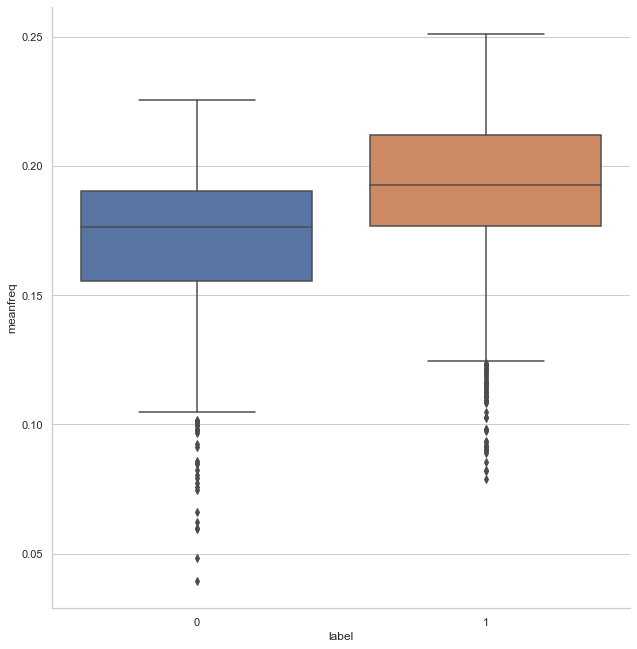

In [68]:
plot_male_female('meanfreq')

## Checando por valores de feature nulos 

#### Não poderiamos alimentar com modelos nulos, portanto precisamos validar se alguma das amostras do dataset apresenta uma feature nula

In [69]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

#### Nenhuma das classes possui valores nulos, porém se fosse o caso poderiamos utilizar um [SimpleInputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) para substituir os valores ou simplesmente descartá-los

## Separação Amostras e Labels

In [70]:
X, y = df.loc[:, df.columns!='label'], df.loc[:, 'label']
X.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274


# Classificação

#### O método de validação cruzada utilizado será o K-Fold estratificado onde cada fold possui classes respeitando a distribuição dos dados. Como apresentado acima, a distribuição das classes é uniforme, portanto o treino será balanceado.

#### Utilizaremos as métricas de acurácia e f1 score para avaliar os modelos.

#### Como observamos que algumas features possuem alta correlação entre sim, utilizaremos os redutores de dimensionalidade PCA e SVD para testar essa hipótese. Será variado de 1 até N_features-1, neste caso, 19.

In [ ]:
cv = StratifiedKFold(n_splits=5,random_state=9 ,shuffle=True)
scores = {'acc' :make_scorer(accuracy_score), 
        'f1':make_scorer(f1_score)}

N_FEATURES_OPTIONS = list(range(1, X.shape[1]))
reducer_labels = ["PCA", "SVD"]
param_grid = [
    {
        "reduce_dim": [PCA(), TruncatedSVD()],
        "reduce_dim__n_components": N_FEATURES_OPTIONS,
    }
]


### Utilizaremos a estrutura de pipelines em GridSeach para testar todas as combinações redutores de dimensionalidade e numero de features.

## LDA

### O primeiro classificador testado será o LDA, se o problema for uma classificação linear simples é provável que o LDA perfome bem

In [ ]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", LinearDiscriminantAnalysis()),
    ]
)
grid_LDA = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)

In [ ]:
grid_LDA.fit(X, y)

#### Na tabela cv_results_ resultado das iterações do GridSearch teremos os resultados.  

# MUDAR O GRÁFICO PARA SCATTER LIGADO E INTRODUZIR AS ACCURÁCIAS DE TREINO

In [ ]:
results_LDA = pd.DataFrame(grid_LDA.cv_results_)
results_LDA[['params', 'param_reduce_dim__n_components','mean_train_acc', 'mean_train_f1','mean_test_acc','mean_test_f1']]

In [ ]:
mean_scores = np.array(results_LDA["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("acurácia LDA utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## SVC

In [16]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", SVC(kernel='linear', C=10, gamma='scale')),
    ]
)

grid_SVC = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)
grid_SVC.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify',
                                        SVC(C=10, kernel='linear'))]),
             param_grid=[{'reduce_dim': [PCA(n_components=12), TruncatedSVD()],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [17]:
results_SVC = pd.DataFrame(grid_SVC.cv_results_)
results_SVC[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",1,0.682138,0.688217
1,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",2,0.831757,0.813914
2,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",3,0.828916,0.810979
3,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",4,0.842174,0.821778
4,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",5,0.887309,0.882645
5,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",6,0.887942,0.883335
6,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",7,0.942234,0.941714
7,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",8,0.942865,0.942345
8,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",9,0.974433,0.974419
9,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",10,0.973803,0.973750


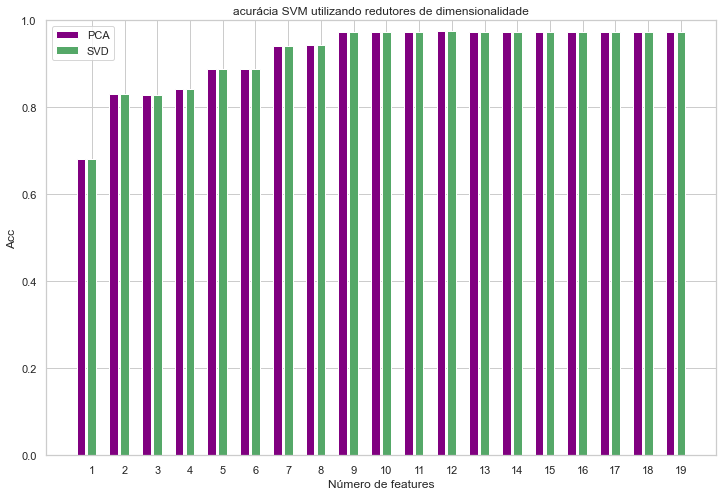

In [18]:
mean_scores = np.array(results_SVC["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("acurácia SVM utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## Random Forest

In [19]:
pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("reduce_dim", "passthrough"),
        ("classify", RandomForestClassifier()),
    ]
)
grid_RandomForest = GridSearchCV(pipe, param_grid=param_grid, scoring=scores, refit="acc", cv=cv, return_train_score=True)
grid_RandomForest.fit(X, y)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reduce_dim', 'passthrough'),
                                       ('classify', RandomForestClassifier())]),
             param_grid=[{'reduce_dim': [PCA(n_components=12),
                                         TruncatedSVD(n_components=15)],
                          'reduce_dim__n_components': [1, 2, 3, 4, 5, 6, 7, 8,
                                                       9, 10, 11, 12, 13, 14,
                                                       15, 16, 17, 18, 19]}],
             refit='acc',
             scoring={'acc': make_scorer(accuracy_score),
                      'f1': make_scorer(f1_score)})

In [20]:
results_RandomForest = pd.DataFrame(grid_RandomForest.cv_results_)
results_RandomForest[['params', 'param_reduce_dim__n_components','mean_test_acc','mean_test_f1']]

,params,param_reduce_dim__n_components,mean_test_acc,mean_test_f1
0,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",1,0.649622,0.646079
1,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",2,0.827645,0.821571
2,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",3,0.844385,0.837829
3,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",4,0.879412,0.874586
4,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",5,0.935293,0.934432
5,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",6,0.946657,0.945754
6,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",7,0.961494,0.961350
7,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",8,0.963071,0.962903
8,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",9,0.969697,0.969610
9,"{'reduce_dim': PCA(n_components=12), 'reduce_d...",10,0.968750,0.968709


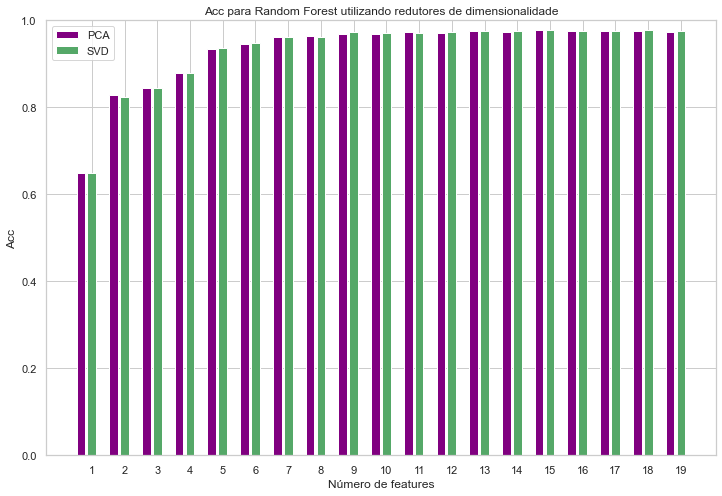

In [21]:
mean_scores = np.array(results_RandomForest["mean_test_acc"])
mean_scores = mean_scores.reshape(-1, len(N_FEATURES_OPTIONS))

bar_offsets = np.arange(len(N_FEATURES_OPTIONS)) * (len(reducer_labels) + 1) + 0.5
plt.figure(figsize=(12,8))
COLORS = ["Purple", "g", "r"]
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Acc para Random Forest utilizando redutores de dimensionalidade")
plt.xlabel("Número de features")
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel("Acc")
plt.ylim((0, 1))
plt.legend(loc="upper left")

plt.show()

## NN

In [ ]:
accs = []
for i in range(1,10):
    for j in range(1,10):
        print(f'iteration {i}.{j}...')
        for train_index, test_index in cv.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y[train_index], y[test_index]
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train, y_train)
            X_test = scaler.transform(X_test)
            
            ANN = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(i,j), max_iter=2000).fit(X_train,y_train)
            accs.append([accuracy_score(y_train, ANN.predict(X_train)), accuracy_score(y_test, ANN.predict(X_test))])

iteration 1.1...
iteration 1.2...
iteration 1.3...
iteration 1.4...
iteration 1.5...
iteration 1.6...
iteration 1.7...
iteration 1.8...
iteration 1.9...
iteration 2.1...
iteration 2.2...
iteration 2.3...
iteration 2.4...
iteration 2.5...
iteration 2.6...
iteration 2.7...
iteration 2.8...
iteration 2.9...
iteration 3.1...
iteration 3.2...
iteration 3.3...
iteration 3.4...
iteration 3.5...
iteration 3.6...
iteration 3.7...
iteration 3.8...
iteration 3.9...
iteration 4.1...
iteration 4.2...
iteration 4.3...
iteration 4.4...
iteration 4.5...
iteration 4.6...
iteration 4.7...
iteration 4.8...
iteration 4.9...
iteration 5.1...
iteration 5.2...
iteration 5.3...
iteration 5.4...
iteration 5.5...
iteration 5.6...
iteration 5.7...
iteration 5.8...
iteration 5.9...
iteration 6.1...
iteration 6.2...
iteration 6.3...
iteration 6.4...
iteration 6.5...
iteration 6.6...
iteration 6.7...
iteration 6.8...
iteration 6.9...
iteration 7.1...
iteration 7.2...
iteration 7.3...
iteration 7.4...
iteration 7.5.

In [ ]:
acc

## IDEIAS PARA APRIMORAMENTO

- Ver quais features são menos relevantes, i.e, tem mais correlação entre si. 
- Levantar hipóteses sobre as features
- Descrição das Features.
- SVM fine tuning
- Comparar os resultados
- [Curvas de aprendizado](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py)
- MUDAR O GRÁFICO DOS RESULTADOS PARA SCATTER LIGADO. INTRODUZIR AS ACCURÁCIAS DE TREINO